Image Retrieval<br />
https://towardsdatascience.com/reverse-image-search-using-auto-encoders-afbf906970f5<br />
https://medium.com/change-the-world-with-technology/%E6%9D%8E%E5%AE%8F%E6%AF%85%E8%80%81%E5%B8%AB-auto-encoder-2017-spring-%E7%AD%86%E8%A8%98-ba20492512e8

using fashion MNIST to do Image Retrieval

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
print(tf.__version__)

2.2.0-rc3


In [0]:
(train_x, _), (test_x, _) = tf.keras.datasets.fashion_mnist.load_data()

把圖片輾平成一維做輸入-> 28×28=784<br />
reshaping image(image shape:28×28) to one-dim ->  28×28=784

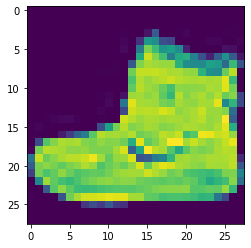

In [3]:
train_x = train_x.reshape(train_x.shape[0], -1).astype(np.float32)/float(255)
test_x = test_x.reshape(test_x.shape[0], -1).astype(np.float32)/float(255)
plt.imshow(train_x[0,:].reshape(28,28))

about PCA/ZCA<br />
https://github.com/hadrienj/Preprocessing-for-deep-learning<br />
https://my.oschina.net/findbill/blog/543485<br />

![ZCA](https://pic1.zhimg.com/v2-896914b606c33fc1e23b5360bcc3d03c_r.jpg)

Before PCA/ZCA, it is not necessary to standardize, standardization is only because it is a feature.


In [0]:
class preprocess_data:
  def __init__(self, data):
    self.mean = self.mean(data)
    self.std = self.std(data)

  @staticmethod
  def mean(x):
    return np.mean(x, axis=0)

  @staticmethod
  def std(x):
    return np.std(x, axis=0)
  
  def calculateCovariance(self, x):
    lenX = x.shape[0]
    x = x - self.mean
    covariance = x.T.dot(x)/lenX
    return covariance

  def standardization(self, x):
    return (x - self.mean)/self.std
  
  def ZCA(self, x):
    cov = self.calculateCovariance(x) #使用training set的mean計算covariance
    # cov = np.cov(x, rowvar=False) #使用自己的mean計算covariance
    U,S,V = np.linalg.svd(cov)
    epsilon = 0.1
    x_zca = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(x.T).T
    return x_zca

  def process(self, x):
    return self.ZCA(self.standardization(x))


In [0]:
preprocess = preprocess_data(train_x)
train_x = preprocess.process(train_x)

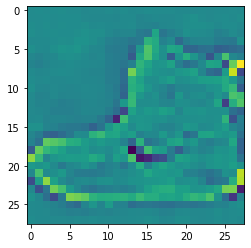

In [6]:
plt.imshow(train_x[0,:].reshape(28,28))

about using keras api:  https://www.tensorflow.org/guide/keras/functional
![deep autoencoder](https://miro.medium.com/max/996/0*6ylJmBMNEkz7nNcX.)


In [11]:
# encoder
encoder_input = keras.Input(shape=(784,), name='original_img')
x = keras.layers.Dense(1000, activation='relu')(encoder_input)
x = keras.layers.Dense(500, activation='relu')(x)
x = keras.layers.Dense(250, activation='relu')(x)
encoder_output = keras.layers.Dense(30, activation='relu')(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

# decoder
decoder_input = keras.Input(shape=(30,), name='encoded_img')
x = keras.layers.Dense(250, activation='relu')(decoder_input)
x = keras.layers.Dense(500, activation='relu')(x)
x = keras.layers.Dense(1000, activation='relu')(x)
decoder_output = keras.layers.Dense(784, activation='relu')(x)
decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

# autoencoder
autoencoder_input = keras.Input(shape=(784,), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_9 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_10 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_11 (Dense)             (None, 30)                7530      
Total params: 1,418,280
Trainable params: 1,418,280
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Out

In [0]:
LEARNING_RATE = 0.001
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam'),
                    loss=tf.keras.losses.MAE)


Using K-fold cross validation<br />
about this: <br/>
https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_2_kfold.ipynb
https://ithelp.ithome.com.tw/articles/10197461

使輸出圖片越接近輸入圖片越好

In [13]:
BATCH_SIZE = 256
N_SPLITS = 10
EPOCHS = 5

#shuffle training set
np.take(train_x, np.random.rand(train_x.shape[0]).argsort(), axis=0, out=train_x) 

# cross validation
kf = KFold(n_splits=N_SPLITS)

for train_index, val_index in kf.split(train_x): # total repaeat N_SPLITS * EPOCHS times (full training set)
  # (x,y) = (sample ,sample)
  training_set = tf.data.Dataset.from_tensor_slices((train_x[train_index], train_x[train_index])).batch(BATCH_SIZE, drop_remainder=True)
  validation_set = tf.data.Dataset.from_tensor_slices((train_x[val_index], train_x[val_index])).batch(BATCH_SIZE, drop_remainder=True)
  autoencoder.fit(training_set, epochs=EPOCHS, validation_data=validation_set)

Epoch 1/5
210/210 [==============================] - 19s 90ms/step - loss: 0.3889 - val_loss: 0.3899
Epoch 2/5
210/210 [==============================] - 19s 89ms/step - loss: 0.3877 - val_loss: 0.3887
Epoch 3/5
210/210 [==============================] - 19s 90ms/step - loss: 0.3860 - val_loss: 0.3868
Epoch 4/5
210/210 [==============================] - 19s 89ms/step - loss: 0.3828 - val_loss: 0.3826
Epoch 5/5
210/210 [==============================] - 19s 90ms/step - loss: 0.3786 - val_loss: 0.3788
Epoch 1/5
210/210 [==============================] - 19s 88ms/step - loss: 0.3751 - val_loss: 0.3766
Epoch 2/5
210/210 [==============================] - 19s 88ms/step - loss: 0.3725 - val_loss: 0.3748
Epoch 3/5
210/210 [==============================] - 18s 88ms/step - loss: 0.3705 - val_loss: 0.3737
Epoch 4/5
210/210 [==============================] - 19s 89ms/step - loss: 0.3688 - val_loss: 0.3725
Epoch 5/5
210/210 [==============================] - 18s 88ms/step - loss: 0.3673 - val_los

In [0]:
autoencoder.save("0418_autoencoder.h5")
encoder.save("0418_encoder.h5")
decoder.save("0418_decoder.h5")